# Credit Card Application Approval

## Initial Setup

### Importing necessary modules

In [1]:
# Installing necessary dependent packages
!pip install -q ipython-autotime
!pip install -q pyspark
!pip install -q tqdm

# Loading autotime for the notebook
%load_ext autotime

time: 2.28 ms (started: 2022-07-22 10:05:55 +00:00)


In [2]:
# SparkSession
from pyspark.sql import SparkSession

# PySpark SQL function and Types
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window as W

# PySpark ML
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import (Bucketizer, 
                                BucketedRandomProjectionLSH, 
                                MinMaxScaler, 
                                OneHotEncoder,
                                QuantileDiscretizer, 
                                StringIndexer, 
                                VectorAssembler)
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Python Utilities
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns
import time

from functools import reduce
from scipy.stats import ks_2samp
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Tuple, Union


from dataclasses import dataclass

print(f"Automatic Garbage Collection is Enables: {gc.isenabled()}")
print("Garbage collection thresholds:", gc.get_threshold())

Automatic Garbage Collection is Enables: True
Garbage collection thresholds: (700, 10, 10)
time: 2.09 s (started: 2022-07-22 10:05:55 +00:00)


In [3]:
def download_file_google_drive(id: str, f_name: str, f_save_path: str=""):
    """
    Download file from Google Drive

    Args:
        id (str): Google Drive File ID
        f_name (str): File name
        f_save_path (str): File save path. 
            default: Current working directory
    """
    import os, requests

    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    f_save_path = os.getcwd() if not f_save_path else f_save_path.rstrip("/")
    destination = f"{f_save_path}/{f_name}"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

time: 17.3 ms (started: 2022-07-22 10:05:57 +00:00)


In [4]:
data_files = {"1wPn1ASPTyYUVQMT9hR6SUOEGeIS4BNEd": "credit_record.csv", 
              "1QvZGzdJIOr0xQuRhE-O5LLIxNqow-vXE": "application_record.csv"}
for file_id, file_name in data_files.items():
    download_file_google_drive(file_id, file_name)

time: 10.6 s (started: 2022-07-22 10:05:57 +00:00)


### Start Spark Application

In [5]:
spark = SparkSession.builder.master("local") \
                            .appName("Credit_Card_Applitcation_Approval") \
                            .config("spark.ui.port", "4050") \
                            .config("spark.submit.deployMode", "client") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "15g") \
                            .config("spark.executor.cores", 4) \
                            .getOrCreate()

time: 7.21 s (started: 2022-07-22 10:06:08 +00:00)


### Data Ingestion

Readin in the data from `credit_record.csv` and `application_record.csv`

In [6]:
credit_record_df = spark.read.options(header="True", 
                                      inferSchema="True",
                                      delimiter=",").csv("/content/credit_record.csv")
credit_record_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)

time: 9.51 s (started: 2022-07-22 10:06:15 +00:00)


In [7]:
application_record_df = spark.read.options(header="True", 
                                           inferSchema="True",
                                           delimiter=",").csv("/content/application_record.csv")
application_record_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)

time: 2.25 s (started: 2022-07-22 10:06:25 +00:00)


In [8]:
print(f"Credit Record count: {credit_record_df.count()}")
print(f"Application Record count: {application_record_df.count()}")

Credit Record count: 1048575
Application Record count: 438557
time: 1.63 s (started: 2022-07-22 10:06:27 +00:00)


## Data Analysis

In [9]:
# Garbage Collections
print(f"Garbage Collector collected {gc.collect()} objects.")

Garbage Collector collected 65 objects.
time: 110 ms (started: 2022-07-22 10:06:29 +00:00)


In [10]:
credit_record_df.filter(credit_record_df.ID==5001711).show()

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
+-------+--------------+------+

time: 1.67 s (started: 2022-07-22 10:06:29 +00:00)




1.   The customer has not taken any loan for the current month. - This statement is true because for month 0, the status is marked as X, which means that the customer has not taken any loan.
2.   The customer has defaulted by 1-29 days in the past three months. - This statement is correct, as the status of the customer for the past three months has been shown as 0, which implies that the customer has defaulted each of these months by 1-29 days.



#### Removing rows with duplicate ID column from `application_record_df`

There are rows with duplicate IDs and details among them is wildly different.

In [11]:
application_record_df = application_record_df.dropDuplicates(["ID"])
application_record_df.count()

438510

time: 2.78 s (started: 2022-07-22 10:06:30 +00:00)


### Credit record feature engineering

#### Creating column with months on the record

Adding a `MONTHS_ON_RECORD` column signifying the number of months the customer has on record.

In [12]:
credit_record_df = credit_record_df.withColumn("MONTHS_ON_RECORD", 
                                               F.count("ID").over(W.partitionBy("ID"))
                                                .cast(T.IntegerType()))

time: 82.9 ms (started: 2022-07-22 10:06:33 +00:00)


#### Creating column with Good or Bad Debt

Adding a `GOOD_BAD_DEBT` column signifying if a month's status is considered as Good or Bad Debt.

In [13]:
# Mapping the statuses. Customer with 60 or more days overdue is considered as a delinquent.
# Mapping 0 for delinquent customers and the rest as 1.
status_dict = {1 : ["X", "C", "0", "1"],
               0 : ["2", "3", "4", "5"]}

time: 1.45 ms (started: 2022-07-22 10:06:33 +00:00)


In [14]:
credit_record_df = credit_record_df.withColumn("GOOD_BAD_DEBT", 
                                               F.when(F.col("STATUS").isin(status_dict[1]), 0)
                                               .otherwise(1))

credit_record_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- MONTHS_ON_RECORD: integer (nullable = false)
 |-- GOOD_BAD_DEBT: integer (nullable = false)

time: 54.1 ms (started: 2022-07-22 10:06:33 +00:00)


In [15]:
credit_record_df = credit_record_df.withColumn("DELINQUENT", 
                                               F.when(F.sum("GOOD_BAD_DEBT").over(W.partitionBy("ID")) > 0, 1)
                                               .otherwise(0))

time: 54.9 ms (started: 2022-07-22 10:06:33 +00:00)


#### Dropping redundant columns

In [16]:
credit_df = credit_record_df.drop("MONTHS_BALANCE", "STATUS", "GOOD_BAD_DEBT")
credit_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_ON_RECORD: integer (nullable = false)
 |-- DELINQUENT: integer (nullable = false)

time: 22.1 ms (started: 2022-07-22 10:06:33 +00:00)


#### Dropping all duplicate rows

In [17]:
credit_df = credit_df.dropDuplicates()
credit_df.groupBy("DELINQUENT").count().show()

+----------+-----+
|DELINQUENT|count|
+----------+-----+
|         1|  667|
|         0|45318|
+----------+-----+

time: 3.94 s (started: 2022-07-22 10:06:33 +00:00)


### Merge Credit and Applications records

Merge credit and application records. For all customers not present in the credit record, mark `MONTHS_ON_RECORD` as 0.

In [18]:
application_record_df = application_record_df.join(credit_df, on=["ID"], how="left")

application_record_df = application_record_df.withColumn("DELINQUENT", 
                                                         F.when(F.col("DELINQUENT").isNull(), -1)
                                                         .otherwise(F.col("DELINQUENT")))

application_record_df = application_record_df.withColumn("MONTHS_ON_RECORD", 
                                                         F.when(F.col("MONTHS_ON_RECORD").isNull(), 0)
                                                         .otherwise(F.col("MONTHS_ON_RECORD")))
application_record_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- MONTHS_ON_RECORD: integer (nullable = true)
 |-- DELINQUENT: integer (nullable = true)

time: 128 ms (started: 2022-07-22 10:06:37 +00:00)


### Splitting the entire application to existing and new customers

Since there are a lot of applicants without a credit history record, it would be better to split applications based on credit history. We will model our data based on the subset of customers with credit history and if needed later we can use the same model to predict application approval status for new customers.

In [19]:
# Applicants with credit history
application_df = application_record_df.filter(F.col("DELINQUENT") >= 0)

# Applicants without credit history
new_applicant_application_df = application_record_df.filter(F.col("DELINQUENT") == -1)

time: 38.8 ms (started: 2022-07-22 10:06:38 +00:00)


In [20]:
print(f"Count of old applicants: {application_df.count()}")
print(f"Count of new applicants: {new_applicant_application_df.count()}")

Count of old applicants: 36457
Count of new applicants: 402053
time: 11.1 s (started: 2022-07-22 10:06:38 +00:00)


## Exploratory Data Analysis

In [21]:
# Garbage Collections
print(f"Garbage Collector collected {gc.collect()} objects.")

Garbage Collector collected 392 objects.
time: 98.6 ms (started: 2022-07-22 10:06:49 +00:00)


### Useful functions

#### Plot Categorical Columns
Plot count of categorical column against target (`DELINQUENT`) column

In [22]:
def plot_categorical_column(pandas_df: pd.core.frame.DataFrame, column: str, r: int=30, xlabels: List[int]=None) -> None:
    """
    Plot count categorical column against target, "DELINQUENT", column.
    """
    plt.figure(figsize = (20,5))
    plt.subplot(1,2,1)
    ax = sns.countplot(x=column, data = pandas_df[pandas_df["DELINQUENT"] == 0])
    if bool(xlabels):
        ax.set_xticklabels(xlabels)
    plt.title(f"NON-DELINQUENT ({column}) Distribution", fontsize = 15)
    plt.xlabel(column, fontsize = 15)
    plt.xticks(rotation = r,fontsize = 12)
    plt.ylabel('Number of NON-DELINQUENT', fontsize = 15)
    
    plt.subplot(1,2,2)
    ax = sns.countplot(x=column, data = pandas_df[pandas_df.DELINQUENT == 1])
    if bool(xlabels):
        ax.set_xticklabels(xlabels)
    plt.title(f"DELINQUENT ({column}) Distribution", fontsize = 15)
    plt.xlabel(column, fontsize = 15)
    plt.xticks(rotation = r,fontsize = 12)
    plt.ylabel('Number of DELINQUENT', fontsize = 15)
    
    plt.show()

time: 17.4 ms (started: 2022-07-22 10:06:49 +00:00)


#### BoxPlot Numerical Columns
Box plot is used to visualise the data and check for outliers.

In [23]:
def plot_box_column(pandas_df: pd.core.frame.DataFrame, column: str) -> None:
    """
    Plot boxplot numerical column.
    """
    plt.figure(figsize = (20,2))
    sns.boxplot(data=pandas_df, x=column)
    plt.show()

time: 2.41 ms (started: 2022-07-22 10:06:49 +00:00)


### Dealing with Missing Values

In [24]:
application_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) \
                       for c in application_record_df.columns]).show()

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+----------------+----------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|MONTHS_ON_RECORD|DELINQUENT|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+----------------+----------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|             

Only column `OCCUPATION_TYPE` has null values. Imputing the null values in this column to be "Not identified"

In [25]:
application_df = application_df.na.fill(value="Not identified",subset=["OCCUPATION_TYPE"])
application_df.groupBy("OCCUPATION_TYPE").count().show(truncate=False)

+---------------------+-----+
|OCCUPATION_TYPE      |count|
+---------------------+-----+
|Managers             |3012 |
|HR staff             |85   |
|Medicine staff       |1207 |
|Accountants          |1241 |
|Laborers             |6211 |
|Cleaning staff       |551  |
|Private service staff|344  |
|Drivers              |2138 |
|Sales staff          |3485 |
|Not identified       |11323|
|Realty agents        |79   |
|IT staff             |60   |
|Security staff       |592  |
|Secretaries          |151  |
|Low-skill Laborers   |175  |
|Core staff           |3591 |
|Cooking staff        |655  |
|High skill tech staff|1383 |
|Waiters/barmen staff |174  |
+---------------------+-----+

time: 5.33 s (started: 2022-07-22 10:07:00 +00:00)


### Checking for Incorrect Data

#### Creating 'Pensioner' occupation type for all pensioners, substantially reducing 'Not identified' group

In [26]:
application_df = application_df.withColumn("OCCUPATION_TYPE", 
                                           F.when((F.col("NAME_INCOME_TYPE") == "Pensioner") & 
                                                  (F.col("OCCUPATION_TYPE") == "Not identified"), "Pensioner")
                                           .otherwise(application_df["OCCUPATION_TYPE"]))

time: 45.9 ms (started: 2022-07-22 10:07:05 +00:00)


In [27]:
application_df.groupBy("DAYS_EMPLOYED").agg(F.count("ID")).sort(F.col("DAYS_EMPLOYED").desc()).show()

+-------------+---------+
|DAYS_EMPLOYED|count(ID)|
+-------------+---------+
|       365243|     6135|
|          -17|        3|
|          -43|        1|
|          -65|        2|
|          -66|        1|
|          -70|        4|
|          -71|        1|
|          -73|       17|
|          -78|        1|
|          -79|        1|
|          -88|        2|
|          -89|        5|
|          -91|        6|
|          -92|        3|
|          -93|        9|
|          -94|        7|
|          -95|       17|
|          -96|       37|
|          -97|       15|
|          -98|        1|
+-------------+---------+
only showing top 20 rows

time: 5.33 s (started: 2022-07-22 10:07:05 +00:00)


In [28]:
application_df.filter(F.col("DAYS_EMPLOYED") > 0).groupBy("NAME_INCOME_TYPE").count().show()

+----------------+-----+
|NAME_INCOME_TYPE|count|
+----------------+-----+
|       Pensioner| 6135|
+----------------+-----+

time: 5 s (started: 2022-07-22 10:07:11 +00:00)


In [29]:
# Adjusting days employed, as the people who had the wrong value (pensioners), did not work at all
application_df = application_df.withColumn("DAYS_EMPLOYED", F.when(F.col("DAYS_EMPLOYED") > 0, 0)
                                                            .otherwise(F.col("DAYS_EMPLOYED")))

time: 20.5 ms (started: 2022-07-22 10:07:16 +00:00)


### Cleaning Up Data and Dealing with Outliers

#### Dealing with outliers for `CNT_CHILDREN` & `CNT_FAM_MEMBERS`

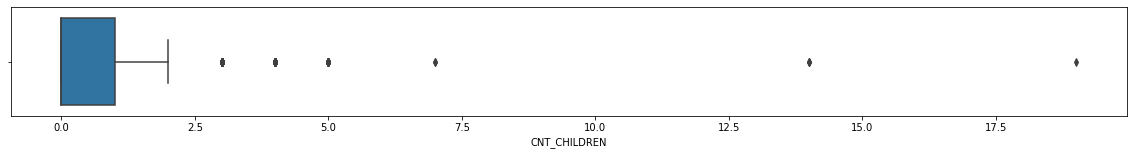

time: 8.61 s (started: 2022-07-22 10:07:16 +00:00)


In [30]:
plot_box_column(pandas_df=application_df.toPandas(), column="CNT_CHILDREN")

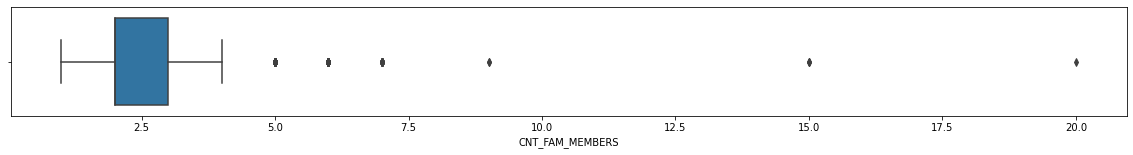

time: 3.63 s (started: 2022-07-22 10:07:24 +00:00)


In [31]:
plot_box_column(pandas_df=application_df.toPandas(), column="CNT_FAM_MEMBERS")

Removing all rows with column `CNT_CHILDREN` greater than 3 & column `CNT_FAM_MEMBERS` greater than 5.

In [32]:
application_df = application_df.filter(F.col("CNT_CHILDREN") < 4)
application_df = application_df.filter(F.col("CNT_FAM_MEMBERS") < 6)

time: 47.5 ms (started: 2022-07-22 10:07:28 +00:00)


#### Converting `DAYS_EMPLOYED` to be absolute


In [33]:
application_df = application_df.withColumn("DAYS_EMPLOYED", F.abs(F.col("DAYS_EMPLOYED")))

time: 25.2 ms (started: 2022-07-22 10:07:28 +00:00)


#### Dealing with outliers in `DAYS_EMPLOYED`

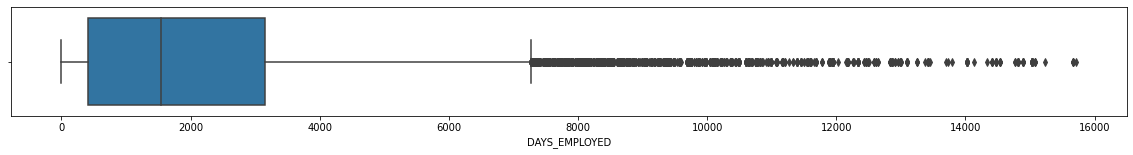

time: 9.19 s (started: 2022-07-22 10:07:28 +00:00)


In [34]:
plot_box_column(pandas_df=application_df.toPandas(), column="DAYS_EMPLOYED")

In [35]:
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]
quantile_col_name = f"percentile_approx(DAYS_EMPLOYED, array{tuple(quantiles)}, 1000000)"
days_employed_quantiles = application_df.select(F.col("DAYS_EMPLOYED")) \
                                        .agg(F.percentile_approx(F.col("DAYS_EMPLOYED"), quantiles, F.lit(1000000))) \
                                        .collect()[0][quantile_col_name]
print(f"Quantiles: {quantiles}")
print(f"DAYS_EMPLOYED: {days_employed_quantiles}")

Quantiles: [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]
DAYS_EMPLOYED: [405, 1540, 3153, 5345, 7205, 10758, 14810, 15661]
time: 5.26 s (started: 2022-07-22 10:07:37 +00:00)


In [36]:
application_df.filter(F.col("DAYS_EMPLOYED")>days_employed_quantiles[quantiles.index(0.999)]).count()

31

time: 4.91 s (started: 2022-07-22 10:07:43 +00:00)


Dropping records at 99.9 Perctile of Days Employed

In [37]:
threshold_quantile = 0.999
application_df = application_df.filter(F.col("DAYS_EMPLOYED") < days_employed_quantiles[quantiles.index(threshold_quantile)])

time: 12.6 ms (started: 2022-07-22 10:07:47 +00:00)


#### Creating buckets for `DAYS_EMPLOYED`

Chosing number of buckets to 7 such that all buckets have roughly the same number of elements and each bucket has at least more than 5% of the total number of data.

In [38]:
discretizer = QuantileDiscretizer(numBuckets=7, inputCol="DAYS_EMPLOYED", outputCol="DAYS_EMPLOYED_BUCKET")
application_df = discretizer.fit(application_df).transform(application_df)

time: 4.86 s (started: 2022-07-22 10:07:48 +00:00)


#### Convert negative values to absolute and bin the AGE column.

In [39]:
application_df = application_df.withColumn("AGE", F.round(F.abs(F.col("DAYS_BIRTH")/365.25)))

discretizer = QuantileDiscretizer(numBuckets=7, inputCol="AGE", outputCol="AGE_BUCKET")
application_df = discretizer.fit(application_df).transform(application_df)

time: 5.95 s (started: 2022-07-22 10:07:52 +00:00)


In [40]:
application_df.groupBy("AGE_BUCKET").count().show()

+----------+-----+
|AGE_BUCKET|count|
+----------+-----+
|       0.0| 4495|
|       1.0| 4980|
|       4.0| 5935|
|       3.0| 5194|
|       2.0| 5286|
|       6.0| 5730|
|       5.0| 4709|
+----------+-----+

time: 4.87 s (started: 2022-07-22 10:07:58 +00:00)


#### Creating buckets for `MONTHS_ON_RECORD`
Chosing number of buckets to 7 such that all buckets have roughly the same number of elements and each bucket has at least more than 5% of the total number of data.

In [41]:
bucketizer = Bucketizer(splits=[0, 10, 20, 30, 40, 50, 60, 70], 
                        inputCol="MONTHS_ON_RECORD", outputCol="MONTHS_ON_RECORD_BUCKET")
application_df = bucketizer.setHandleInvalid("keep").transform(application_df)

time: 96.4 ms (started: 2022-07-22 10:08:03 +00:00)


#### Outlier clean up for `AMT_INCOME_TOTAL`

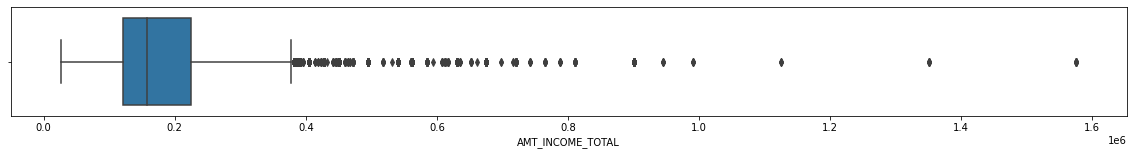

time: 8.43 s (started: 2022-07-22 10:08:03 +00:00)


In [42]:
plot_box_column(pandas_df=application_df.toPandas(), column="AMT_INCOME_TOTAL")

Based on the above plot, we are going to consider Income above `1 Million` as an outlier

In [43]:
application_df = application_df.filter(F.col("AMT_INCOME_TOTAL") < 1000000)

time: 15.6 ms (started: 2022-07-22 10:08:12 +00:00)


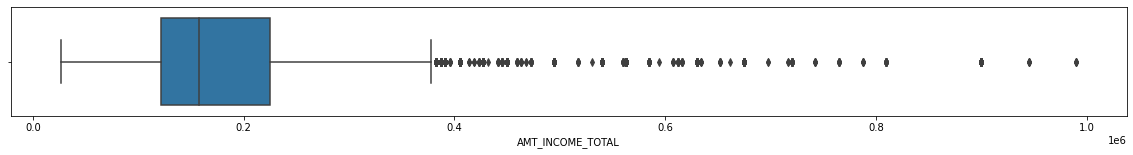

time: 8.24 s (started: 2022-07-22 10:08:12 +00:00)


In [44]:
plot_box_column(pandas_df=application_df.toPandas(), column="AMT_INCOME_TOTAL")

#### Creating buckets for `AMT_INCOME_TOTAL`

Choosing the number of buckets to 7 such that all buckets have roughly the same number of elements and each bucket has at least more than 5% of the total number of data.

In [45]:
discretizer = QuantileDiscretizer(numBuckets=7, inputCol="AMT_INCOME_TOTAL", outputCol="AMT_INCOME_TOTAL_BUCKET")

application_df = discretizer.fit(application_df).transform(application_df)

time: 5.01 s (started: 2022-07-22 10:08:20 +00:00)


In [46]:
application_df.groupBy("AMT_INCOME_TOTAL_BUCKET").count().show()

+-----------------------+-----+
|AMT_INCOME_TOTAL_BUCKET|count|
+-----------------------+-----+
|                    0.0| 5087|
|                    1.0| 5048|
|                    4.0| 6351|
|                    3.0| 3855|
|                    2.0| 5310|
|                    6.0| 6227|
|                    5.0| 4434|
+-----------------------+-----+

time: 4.62 s (started: 2022-07-22 10:08:25 +00:00)


### Dropping redundant columns

In [47]:
application_df = application_df.drop("DAYS_BIRTH", "FLAG_MOBIL")
application_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = false)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- MONTHS_ON_RECORD: integer (nullable = true)
 |-- DELINQUENT: integer (nullable = true)
 |-- DAYS_EMPLOYED_BUCKET: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- AGE_BUCKET: double (nullable = true)
 |-- MONTHS_ON_RECORD_BUCKET: double (n

### Converting to pandas dataframe for ease of plotting

In [48]:
application_pd = application_df.toPandas()

time: 9.05 s (started: 2022-07-22 10:08:30 +00:00)


### 1. What is the proportion of females in the applicant customer base?

In [49]:
no_female_applicants = application_df.filter(application_df.CODE_GENDER=="F").count()
total_applicants = application_df.count()
print(f"Percentage of Female applicants: {no_female_applicants*100/total_applicants:3.2f}%")
application_df.groupBy("CODE_GENDER").count().show()

Percentage of Female applicants: 66.99%
+-----------+-----+
|CODE_GENDER|count|
+-----------+-----+
|          F|24327|
|          M|11985|
+-----------+-----+

time: 15.4 s (started: 2022-07-22 10:08:39 +00:00)


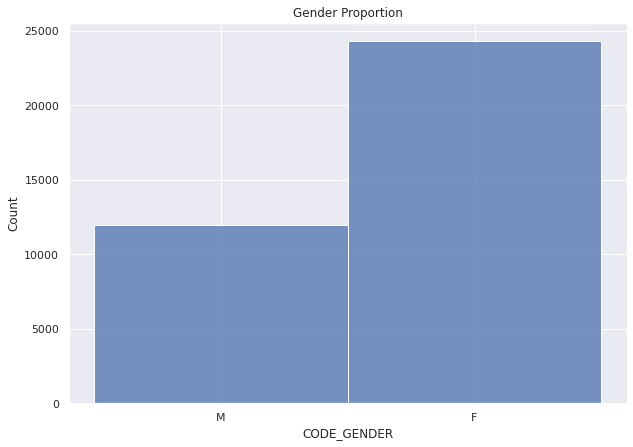

time: 200 ms (started: 2022-07-22 10:08:54 +00:00)


In [50]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.histplot(data=application_pd, x="CODE_GENDER")

plt.ylabel('Count')
plt.xlabel('CODE_GENDER')
plt.title('Gender Proportion')
plt.show()

Female applicants account for 67% of the customer base.

### 2. Is homeownership higher among male applicants or female applicants?

In [51]:
application_df.groupBy(["CODE_GENDER", "FLAG_OWN_REALTY"]).count().filter(F.col("FLAG_OWN_REALTY")=="Y").show()

+-----------+---------------+-----+
|CODE_GENDER|FLAG_OWN_REALTY|count|
+-----------+---------------+-----+
|          F|              Y|16748|
|          M|              Y| 7652|
+-----------+---------------+-----+

time: 5.34 s (started: 2022-07-22 10:08:54 +00:00)


In [52]:
application_df.count()

36312

time: 4.42 s (started: 2022-07-22 10:09:00 +00:00)


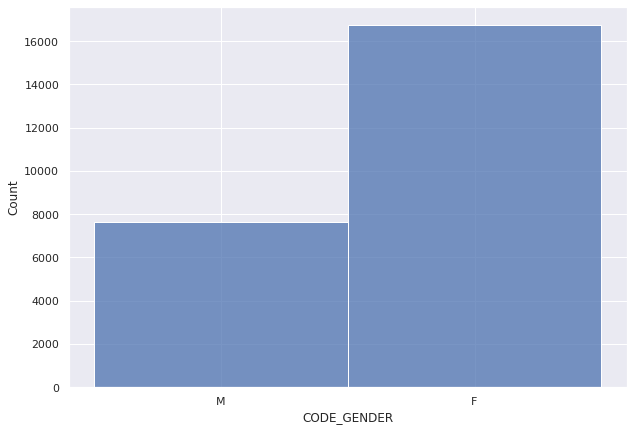

time: 205 ms (started: 2022-07-22 10:09:04 +00:00)


In [53]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.histplot(data=application_pd[application_pd.FLAG_OWN_REALTY == "Y"], x="CODE_GENDER")
plt.show()

Home ownership is higher among female applicants.

### 3. Is there any correlation between the customer's income level and education level?

In [54]:
fig = px.box(application_df.toPandas(), x="NAME_EDUCATION_TYPE", y="AMT_INCOME_TOTAL")
fig.update_xaxes(categoryorder="median descending")
fig.show()

time: 3.02 s (started: 2022-07-22 10:09:04 +00:00)


In [55]:
application_df.groupBy("NAME_EDUCATION_TYPE").agg(F.percentile_approx("AMT_INCOME_TOTAL", 0.5) \
                                                  .alias("AMT_INCOME_TOTAL_MEDIAN")).show(truncate=False)

+-----------------------------+-----------------------+
|NAME_EDUCATION_TYPE          |AMT_INCOME_TOTAL_MEDIAN|
+-----------------------------+-----------------------+
|Academic degree              |270000.0               |
|Incomplete higher            |180000.0               |
|Secondary / secondary special|157500.0               |
|Lower secondary              |135000.0               |
|Higher education             |202500.0               |
+-----------------------------+-----------------------+

time: 5.54 s (started: 2022-07-22 10:09:07 +00:00)


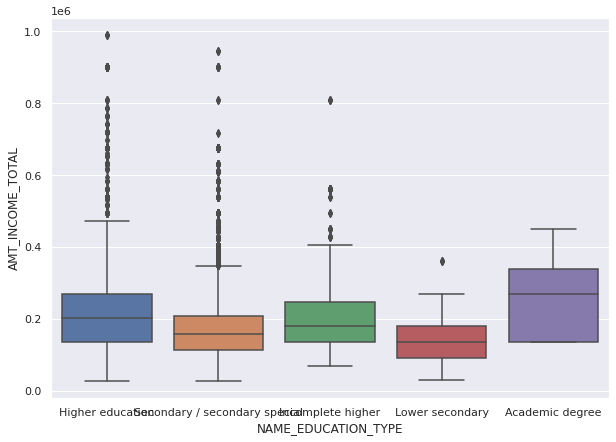

time: 284 ms (started: 2022-07-22 10:09:13 +00:00)


In [56]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.boxplot(data=application_pd, x="NAME_EDUCATION_TYPE", y="AMT_INCOME_TOTAL")
plt.show()

There is a positive correlation between the customer's income level and education level. Customer's with higher education have a higher median income.

### 4. What is the average and median salary of the applicant base?

In [57]:
application_df.select(F.mean("AMT_INCOME_TOTAL").alias("AMT_INCOME_TOTAL_MEAN"), 
                      F.percentile_approx("AMT_INCOME_TOTAL", 0.5, F.lit(1000000)).alias("AMT_INCOME_TOTAL_MEDIAN"))\
                      .show(truncate=False)

+---------------------+-----------------------+
|AMT_INCOME_TOTAL_MEAN|AMT_INCOME_TOTAL_MEDIAN|
+---------------------+-----------------------+
|186130.8493473232    |157500.0               |
+---------------------+-----------------------+

time: 4.53 s (started: 2022-07-22 10:09:13 +00:00)


The applicant base salary average is 187522.009381567 & median is 161100.0

### 5. Is the proportion of bad customers higher for people who own cars?

In [58]:
application_df.filter(F.col("FLAG_OWN_CAR") == "Y").groupBy(["FLAG_OWN_CAR", "DELINQUENT"]).count().show()

+------------+----------+-----+
|FLAG_OWN_CAR|DELINQUENT|count|
+------------+----------+-----+
|           Y|         1|  224|
|           Y|         0|13517|
+------------+----------+-----+

time: 4.84 s (started: 2022-07-22 10:09:18 +00:00)


Among the people who own cars, lower number of them are bad customers.

### 6. Is the proportion of bad customers higher for those living on rent than the rest of the population?

In [59]:
application_df.filter(F.col("DELINQUENT") == 1).groupBy("NAME_HOUSING_TYPE").count() \
                        .withColumn("proportion_pct", 
                                    F.col("count")*100/application_df.filter(F.col("DELINQUENT") == 1).count()).show()

+-------------------+-----+------------------+
|  NAME_HOUSING_TYPE|count|    proportion_pct|
+-------------------+-----+------------------+
|  House / apartment|  539| 87.64227642276423|
|Municipal apartment|   30| 4.878048780487805|
|    Co-op apartment|    3|0.4878048780487805|
|   Rented apartment|    8|1.3008130081300813|
|   Office apartment|    9|1.4634146341463414|
|       With parents|   26| 4.227642276422764|
+-------------------+-----+------------------+

time: 9.01 s (started: 2022-07-22 10:09:23 +00:00)


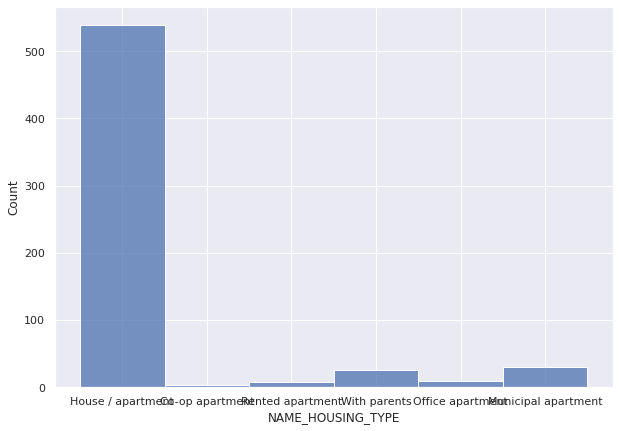

time: 213 ms (started: 2022-07-22 10:09:32 +00:00)


In [60]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.histplot(data=application_pd[application_pd.DELINQUENT == 1], x="NAME_HOUSING_TYPE")
plt.show()

The proportion of bas customers living on rent is significantly lower than the rest of the population. 

### 7. Is the proportion of bad customers higher for those who are single than married customers?

In [61]:
application_df.filter(F.col("DELINQUENT") == 1).groupBy("NAME_FAMILY_STATUS").count() \
                        .withColumn("proportion_pct", 
                                    F.col("count")*100/application_df.filter(F.col("DELINQUENT") == 1).count()).show()

+--------------------+-----+------------------+
|  NAME_FAMILY_STATUS|count|    proportion_pct|
+--------------------+-----+------------------+
|           Separated|   31| 5.040650406504065|
|             Married|  392|63.739837398373986|
|Single / not married|  101|16.422764227642276|
|               Widow|   45| 7.317073170731708|
|      Civil marriage|   46| 7.479674796747967|
+--------------------+-----+------------------+

time: 8.84 s (started: 2022-07-22 10:09:32 +00:00)


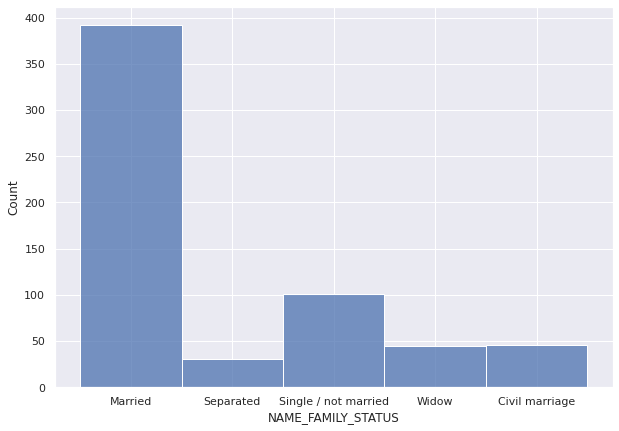

time: 198 ms (started: 2022-07-22 10:09:41 +00:00)


In [62]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.histplot(data=application_pd[application_pd.DELINQUENT == 1], x="NAME_FAMILY_STATUS")
plt.show()

The proportion of bad customers that are single is approx 16% which is lower than the proportion of married customers.

### Categorical Plots

#### Income Types


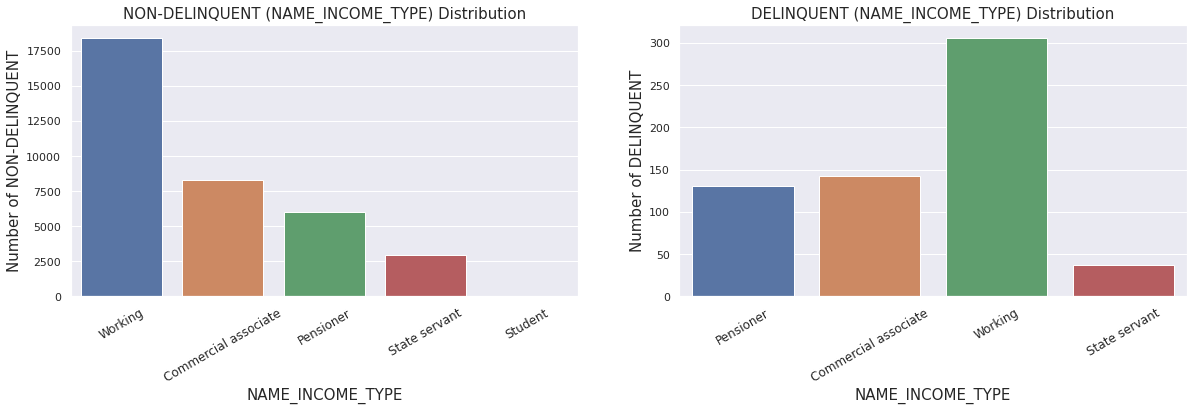

time: 405 ms (started: 2022-07-22 10:09:41 +00:00)


In [63]:
plot_categorical_column(application_pd, "NAME_INCOME_TYPE")

#### Gender

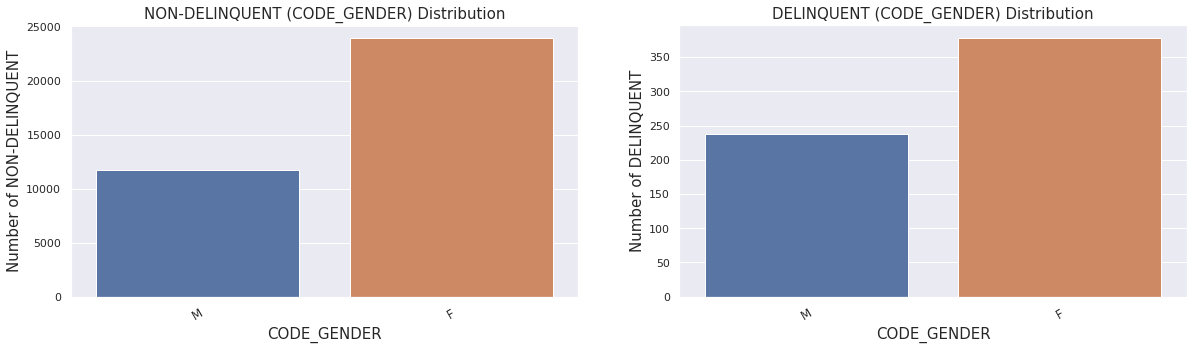

time: 332 ms (started: 2022-07-22 10:09:41 +00:00)


In [64]:
plot_categorical_column(application_pd, "CODE_GENDER")


#### Children Count

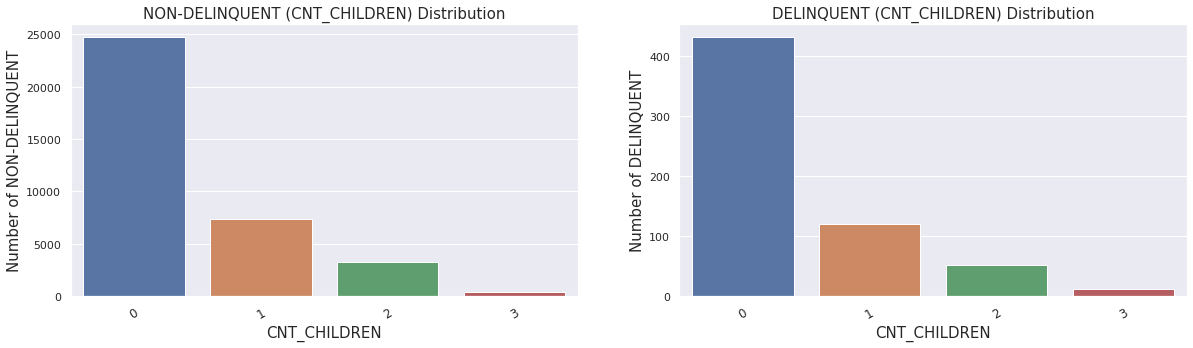

time: 327 ms (started: 2022-07-22 10:09:42 +00:00)


In [65]:
plot_categorical_column(application_pd, "CNT_CHILDREN")

#### Family Member Count

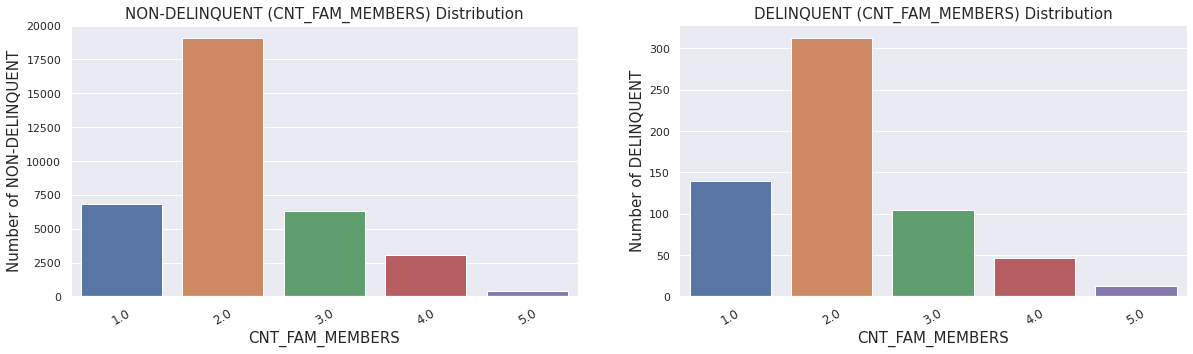

time: 484 ms (started: 2022-07-22 10:09:42 +00:00)


In [66]:
plot_categorical_column(application_pd, "CNT_FAM_MEMBERS")

#### Education Type

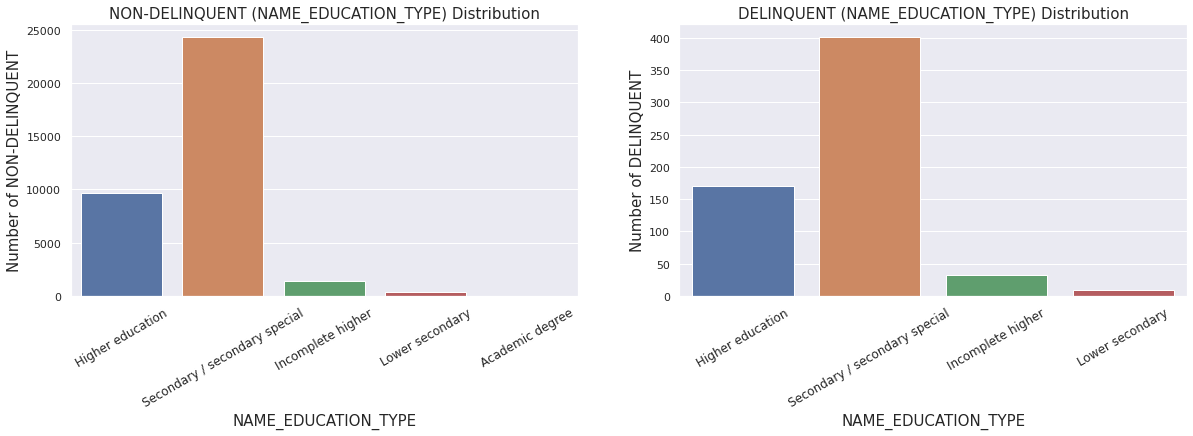

time: 410 ms (started: 2022-07-22 10:09:43 +00:00)


In [67]:
plot_categorical_column(application_pd, "NAME_EDUCATION_TYPE")

#### Name Family Status

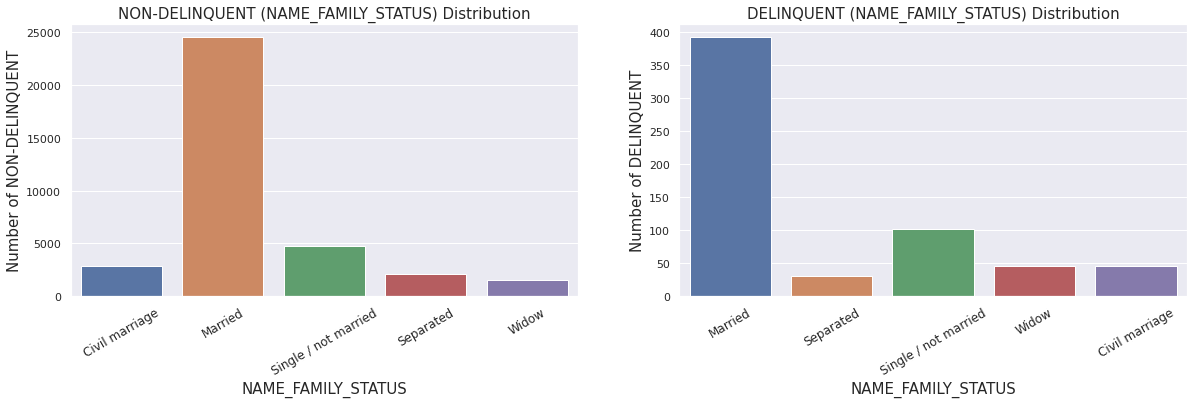

time: 405 ms (started: 2022-07-22 10:09:43 +00:00)


In [68]:
plot_categorical_column(application_pd, "NAME_FAMILY_STATUS")

#### Occupation Type

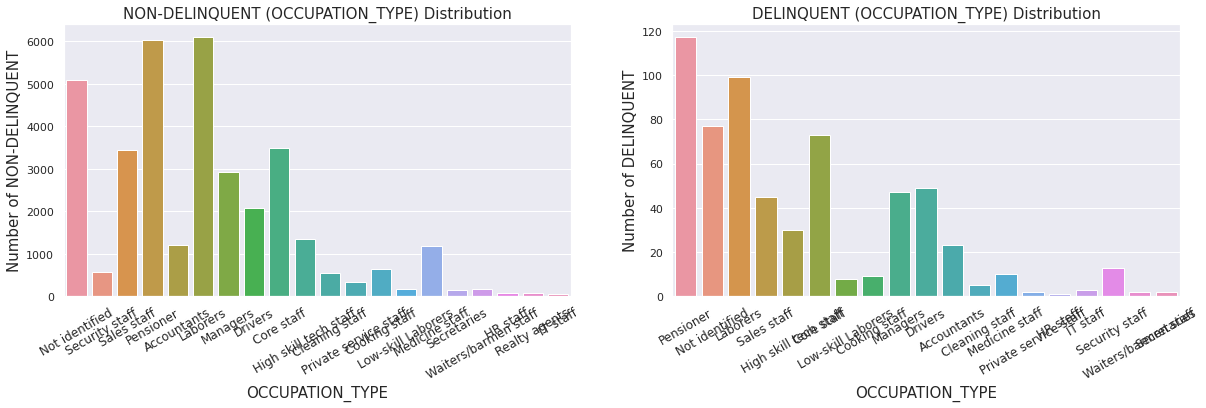

time: 744 ms (started: 2022-07-22 10:09:43 +00:00)


In [69]:
plot_categorical_column(application_pd, "OCCUPATION_TYPE")

#### Name Housing Type 

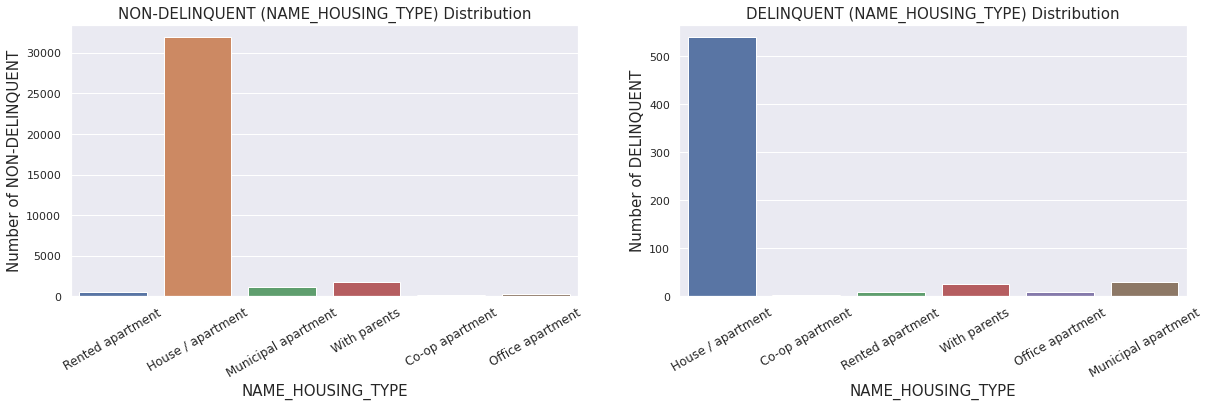

time: 425 ms (started: 2022-07-22 10:09:44 +00:00)


In [70]:
plot_categorical_column(application_pd, "NAME_HOUSING_TYPE")

#### Name Education Type

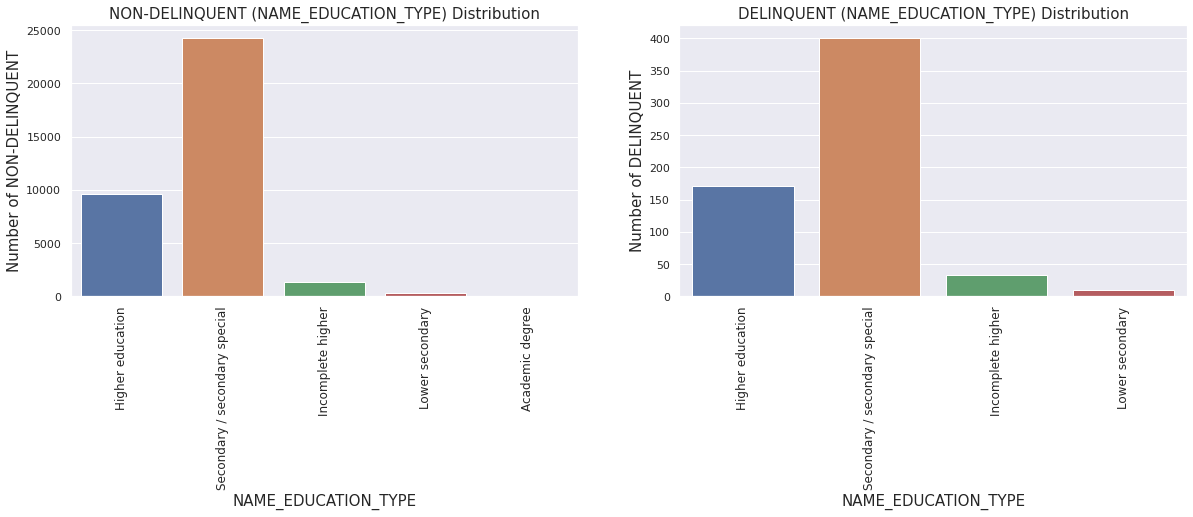

time: 412 ms (started: 2022-07-22 10:09:45 +00:00)


In [71]:
plot_categorical_column(application_pd, "NAME_EDUCATION_TYPE", r=90)

#### Age

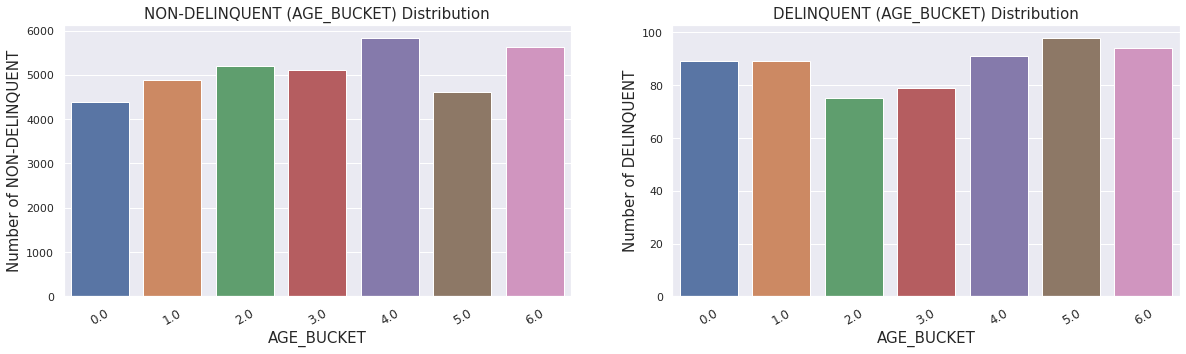

time: 381 ms (started: 2022-07-22 10:09:45 +00:00)


In [72]:
plot_categorical_column(application_pd, "AGE_BUCKET")

#### Months on Record

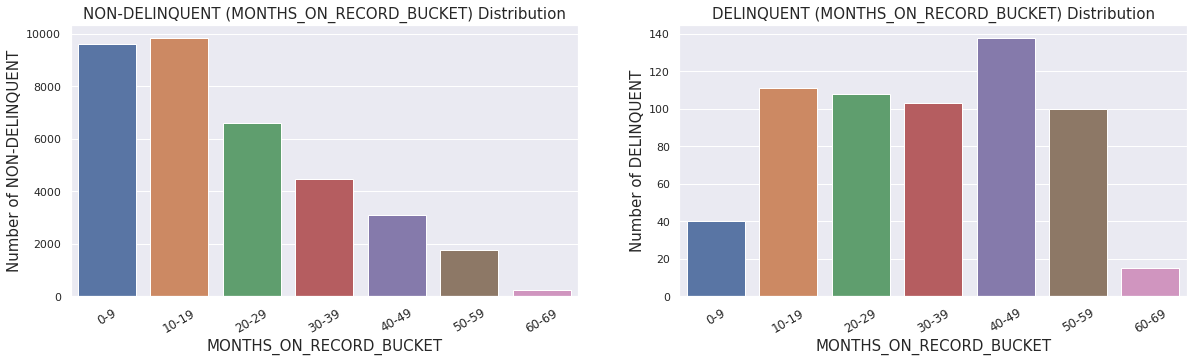

time: 385 ms (started: 2022-07-22 10:09:45 +00:00)


In [73]:
plot_categorical_column(application_pd, "MONTHS_ON_RECORD_BUCKET", 
                        xlabels=["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69"])

#### `AGE_BUCKETS` vs `AMT_INCOME_TOTAL`

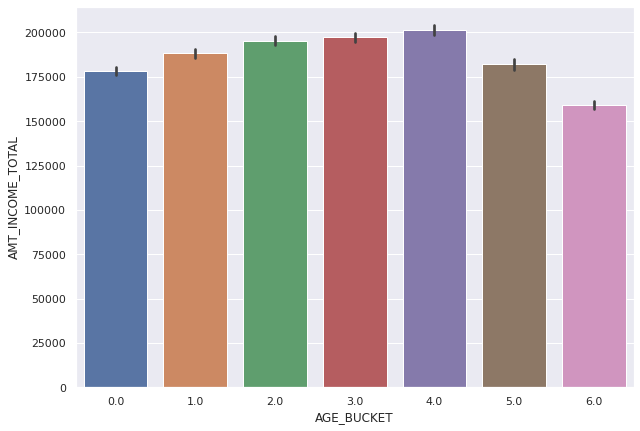

time: 736 ms (started: 2022-07-22 10:09:46 +00:00)


In [74]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.barplot(data=application_pd, x="AGE_BUCKET", y="AMT_INCOME_TOTAL")
plt.show()

## Weight of Evidence (WOE) and Information Value (IV)

In [75]:
# Garbage Collections
print(f"Garbage Collector collected {gc.collect()} objects.")

Garbage Collector collected 45536 objects.
time: 168 ms (started: 2022-07-22 10:09:47 +00:00)


In [76]:
class WOE_IV(object):
    """
    Class for calculating the WOE and IV values in a given dataset.
    
    Args:
        df (pyspark.sql.DataFrame): PySpark dataframe.
        cols_to_woe (List[str]): Columns for which WOE and IV are to be calculated.
        label_column (str): Target column of the data.
        good_label (Union[str, int]): Predicted variable in the form of 1 or 0.
    """
    
    def __init__(self, df: DataFrame, cols_to_woe: List[str], label_column: str, good_label: Union[int, str]):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {} # This is a dictionary which will store all the WOE and IV computed in the latter part of the code

    def fit(self):  
        """
        This method takes the columns in 'cols_to_woe' and calculates the good and bad amounts, 
        and then assigns the WOE values in the dictionary, 'fit_data'.
        """
        NUM_WOE_COLS = len(self.cols_to_woe) # Number of iterations for Progress Bar - Columns
        with tqdm(total=NUM_WOE_COLS) as pbar_columns: # Initialize Columns progress bar
            for col_to_woe in self.cols_to_woe: # Iterating over each column in the list, cols_to_woe
                pbar_columns.set_description(f"Processing Column: {col_to_woe}:", refresh=True) # Set description for columns progress bar
                total_good = self.compute_total_amount_of_good() # Computes the total amount of good labels in the entire dataset
                total_bad = self.compute_total_amount_of_bad() # Computes the total amount of bad labels in the entire dataset
                
                woe_df = self.df.select(col_to_woe) # This dataframe stores the column, col_to_woe from the DataFrame
                categories = woe_df.distinct().collect() # Creates a list of all the distinct categories in the column, col_to_woe

                NUM_CATEGORIES = len(categories) # Number of iterations for Progress Bar - Categories
                with tqdm(total=NUM_CATEGORIES) as pbar_categories: # Initialize Categories progress bar
                    for category_row in categories: # Iterating over each category in the distinct categories of the column
                        category = category_row[col_to_woe]
                        pbar_categories.set_description(f"Processing Category: {category}:", refresh=True) # Set description for categories progress bar
                        
                        # For each category, we calculate the good_amount and bad_amount
                        good_amount = self.compute_good_amount(col_to_woe, category)
                        bad_amount = self.compute_bad_amount(col_to_woe, category)
                        
                        # If the good_amount or bad_amount is 0, we replace it with 0.5, because in the calculation of woe, 
                        # it comes in the denominator resulting in a Nan value which will give an error
                        good_amount = good_amount if good_amount != 0 else 0.5
                        bad_amount = bad_amount if bad_amount != 0 else 0.5

                        # Calculating the fraction of good_amount and bad_amount specific to that category
                        good_dist = good_amount / total_good
                        bad_dist = bad_amount / total_bad

                        # Calling the build_fit_data method which calculates the WOE and IV for the category in the 
                        # column and stores it in the dictionary, fit_data
                        self.build_fit_data(col_to_woe, category, good_dist, bad_dist)
                        pbar_categories.update() # Increments counter for categories progress bar
                pbar_columns.update() # Increments counter for columns progress bar

    def transform(self, df: DataFrame):
        """
        This method creates a column called "col_to_woe + '_woe'" which replaces the given category value with the WOE value.
        It finally returns a final dataframe containing the WOE values in place of the columns.
        """
        def _encode_woe(col_to_woe_):
            return F.coalesce(*[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe'])) \
                                for category, woe_iv in self.fit_data[col_to_woe_].items()])

        for col_to_woe, woe_info in self.fit_data.items():
            # Adds another column to the df containing the final WOE values
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
        """
        Computes the total amount of good labels in the entire dataset.
        """
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
        """
        Computes the total amount of bad labels in the entire dataset.
        """
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
        """
        Computes the total amount of good labels for the specific class in the feature.
        """
        return self.df.select(col_to_woe, self.label_column) \
                      .filter((F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label))\
                      .count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        """
        Computes the total amount of bad labels for the specific class in the feature.
        """
        return self.df.select(col_to_woe, self.label_column) \
                      .filter((F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label))\
                      .count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        """
        Calculates the WOE and value for the specific category and saves it in the woe_info dictionary 
        which is then saved in the fit_data dictionary.
        
        Args:
            col_to_woe (str): Name of the feature.
            category (str): Class of that feature.
            good_dist (float): Fraction of good labels specific to that category.
            bad_dist (float): Fraction of bad labels specific to that category.
        """
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist), # Calculating the WOE value for the category in the column
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist) # Calculating the IV value for the category in the column
            }
        }

        # Adding the feature, col_to_woe to fit_data if not present already
        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        """
        Returns the IV dictionary which contains the IV value for each feature.
        """
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv'] # IV for the feature = IV value for the indiviual categories of the feature (column)
        return iv_dict

time: 108 ms (started: 2022-07-22 10:09:47 +00:00)


In [77]:
ignore_columns = ["DELINQUENT", "ID", "AMT_INCOME_TOTAL", "DAYS_EMPLOYED", "AGE", "MONTHS_ON_RECORD"]
woe_cols = [x for x in application_df.columns if x not in ignore_columns]
woe_cols

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'DAYS_EMPLOYED_BUCKET',
 'AGE_BUCKET',
 'MONTHS_ON_RECORD_BUCKET',
 'AMT_INCOME_TOTAL_BUCKET']

time: 7.45 ms (started: 2022-07-22 10:09:47 +00:00)


In [78]:
target_column = "DELINQUENT"
woe_iv = WOE_IV(df=application_df.select(woe_cols + [target_column]), 
                cols_to_woe=woe_cols, label_column=target_column, 
                good_label=1)

# Weight of Evidence encoding
woe_iv.fit()
application_woe_iv_df = woe_iv.transform(application_df)

# Computing Information Value
information_values = woe_iv.compute_iv()

Processing Category: Incomplete higher::  40%|████      | 2/5 [00:18<00:27,  9.12s/it]
Processing Category: Secondary / secondary special::  40%|████      | 2/5 [00:18<00:27,  9.12s/it]
Processing Category: Secondary / secondary special::  60%|██████    | 3/5 [00:27<00:18,  9.09s/it]
Processing Column: AMT_INCOME_TOTAL_BUCKET:: 100%|██████████| 17/17 [17:53<00:00, 63.13s/it]


time: 17min 53s (started: 2022-07-22 10:09:47 +00:00)


In [79]:
application_woe_iv_df.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+-------------+---------------+----------+----------+---------------+---------------+----------------+----------+--------------------+----+----------+-----------------------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+--------------------+---------------------------+---------------------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_EMPLOYED|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|MONTHS_ON_RECORD

In [80]:
def classify_iv(iv_dict: dict) -> Tuple[dict, dict]:
    relevant_cols = {col: iv for col, iv in iv_dict.items() if iv >= 0.002}
    irrelevant_cols = {col: iv for col, iv in iv_dict.items() if iv < 0.002}
    return (relevant_cols, irrelevant_cols)

def print_relevant_irrelevant_columns(info_vals: dict) -> None:
    relev_cols, irrelev_cols = classify_iv(info_vals)
    print(f"{'Relevant Column': <25} => Information Value")
    print("-"*50)
    for k, v in relev_cols.items():
        print(f"{k: <25} => {v}")
    print("-"*50)
    
    print("\n")
    print("*"*50)
    print("*"*50)
    print("\n")

    print(f"{'Irrelevant Column': <25} => Information Value")
    print("-"*50)
    for k, v in irrelev_cols.items():
        print(f"{k: <25} => {v}")
    print("-"*50)


time: 21.7 ms (started: 2022-07-22 10:27:48 +00:00)


In [81]:
print_relevant_irrelevant_columns(information_values)

Relevant Column           => Information Value
--------------------------------------------------
CODE_GENDER               => 0.013807368685158247
FLAG_OWN_REALTY           => 0.028642883260941228
CNT_CHILDREN              => 0.00538055145546918
NAME_INCOME_TYPE          => 0.017460531817179513
NAME_EDUCATION_TYPE       => 0.009407718021922914
NAME_FAMILY_STATUS        => 0.03024071004955692
NAME_HOUSING_TYPE         => 0.015884264392624376
OCCUPATION_TYPE           => 0.06612374452347357
CNT_FAM_MEMBERS           => 0.014251104825082345
DAYS_EMPLOYED_BUCKET      => 0.04666113062232205
AGE_BUCKET                => 0.01783841332665411
MONTHS_ON_RECORD_BUCKET   => 0.6305378342950805
AMT_INCOME_TOTAL_BUCKET   => 0.006484214460498116
--------------------------------------------------


**************************************************
**************************************************


Irrelevant Column         => Information Value
--------------------------------------------------
FLAG

#### Dropping irrelevant columns

In [82]:
_, irrelevant_cols = classify_iv(information_values)


time: 1.2 ms (started: 2022-07-22 10:27:48 +00:00)


In [83]:
application_df = application_df.drop(*list(irrelevant_cols.keys()))
application_df = application_df.drop(*[col for col in application_df.columns if col.endswith("_BUCKET")])
application_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = false)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- MONTHS_ON_RECORD: integer (nullable = true)
 |-- DELINQUENT: integer (nullable = true)
 |-- AGE: double (nullable = true)

time: 24.2 ms (started: 2022-07-22 10:27:48 +00:00)


## Modelling

In [84]:
# Garbage Collections
print(f"Garbage Collector collected {gc.collect()} objects.")

Garbage Collector collected 800 objects.
time: 126 ms (started: 2022-07-22 10:27:48 +00:00)


### Data Estimators & Transformers

#### StringIndexer Transformation

In [85]:
string_cols = ["CODE_GENDER", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
               "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"]

print(f"Categorical String Columns: {string_cols}")
string_indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_stridx") for column in string_cols]



Categorical String Columns: ['CODE_GENDER', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
time: 37 ms (started: 2022-07-22 10:27:48 +00:00)


#### OneHotEncoder Transformation

In [86]:
categorical_cols =  [f"{col}_stridx" for col in string_cols] + \
                    [col for col in application_df.columns if (col.startswith("FLAG_") and not ("OWN" in col))]

print(f"Categorical Numerical Columns: {categorical_cols}")                                       
ohe_indexers = [OneHotEncoder(inputCol=column, outputCol=f"{column}_ohe") for column in categorical_cols]

Categorical Numerical Columns: ['CODE_GENDER_stridx', 'FLAG_OWN_REALTY_stridx', 'NAME_INCOME_TYPE_stridx', 'NAME_EDUCATION_TYPE_stridx', 'NAME_FAMILY_STATUS_stridx', 'NAME_HOUSING_TYPE_stridx', 'OCCUPATION_TYPE_stridx']
time: 38.1 ms (started: 2022-07-22 10:27:48 +00:00)


#### VectorAssembler Transformation

In [87]:
vector_columns = [f"{col}_ohe" for col in categorical_cols] + \
                    ["DAYS_EMPLOYED", "AMT_INCOME_TOTAL", "AGE", "MONTHS_ON_RECORD", 
                     "CNT_CHILDREN", "CNT_FAM_MEMBERS"]

print(f"Vector Assembler Features: {vector_columns}")

vector_assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")

Vector Assembler Features: ['CODE_GENDER_stridx_ohe', 'FLAG_OWN_REALTY_stridx_ohe', 'NAME_INCOME_TYPE_stridx_ohe', 'NAME_EDUCATION_TYPE_stridx_ohe', 'NAME_FAMILY_STATUS_stridx_ohe', 'NAME_HOUSING_TYPE_stridx_ohe', 'OCCUPATION_TYPE_stridx_ohe', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AGE', 'MONTHS_ON_RECORD', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']
time: 14.5 ms (started: 2022-07-22 10:27:49 +00:00)


#### Pipeline Transformation
Combining all the above stages of Estimators to transform the data.

In [88]:
indexers = string_indexers + ohe_indexers + [vector_assembler]
pipeline = Pipeline(stages=indexers)
application_transformed_df = pipeline.fit(application_df).transform(application_df)

time: 38.7 s (started: 2022-07-22 10:27:49 +00:00)


In [89]:
application_transformed_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = false)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- MONTHS_ON_RECORD: integer (nullable = true)
 |-- DELINQUENT: integer (nullable = true)
 |-- AGE: double (nullable = true)
 |-- CODE_GENDER_stridx: double (nullable = false)
 |-- FLAG_OWN_REALTY_stridx: double (nullable = false)
 |-- NAME_INCOME_TYPE_stridx: double (nullable = false)
 |-- NAME_EDUCATION_TYPE_stridx: double (nullable = false)
 |-- NAME_FAMILY_STATUS_stridx: double (nullable = false)
 |-- NAME_HOUSING_TYPE_stridx: d

### Synthetic Minority Oversampling TEchnique (SMOTE)

Since the data is heavily imbalanced we are going to try 

`SMOTE` is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [90]:
# Garbage Collections
print(f"Garbage Collector collected {gc.collect()} objects.")

Garbage Collector collected 639 objects.
time: 120 ms (started: 2022-07-22 10:28:27 +00:00)


In [91]:
@dataclass
class SmoteConfig():
    """Smote Confirguration."""
    classes: Tuple = (1, 0)
    seed: int = 48
    bucketLength: int= 100
    k: int = 4
    multiplier: int = 3


class Smote(object):
    def __init__(self, df: DataFrame = None, cat_cols: List[str] = None, 
                 num_cols: List[str] = None, label: str = None, 
                 config: SmoteConfig = None, index_suffix: str="_index"):
        """
        Smote class constructor.

        Args:
            df: spark df, original
            cat_cols: Categorical cols to be String Indexed
            num_cols: Numerical cols to be Vector Assembled
            label: prediction target
            index_suffix: will be the suffix after string indexing
        """
        self.df = df
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.label = label
        self.config = config
        self.index_suffix = index_suffix
        self.label_smoted = f"{label}_smoted"

    def pre_process(self):
        """
        String Indexer and Vector Assembler

        Returns:
            vectorized: spark df, after stringindex and vector assemble, ready for smote
            stages_: StringIndexer and VectorAssembler stages
        """
        if self.df.select(self.label).distinct().count() != 2:
            raise ValueError("Target column must have exactly 2 classes")
            
        # only assembled numeric columns into features
        assembler = VectorAssembler(inputCols = self.num_cols, outputCol = 'features')
        
        stages_ = []
        stages_.append(assembler)

        # setting to drop original num cols and cat cols
        drop_cols = self.num_cols
        
        # index the string cols, except possibly for the label col
        str_ind_stages = [StringIndexer(inputCol=col, outputCol=f"{col}{self.index_suffix}").fit(self.df) for col in self.cat_cols]
        stages_ += str_ind_stages
        # also drop cat cols if str index applied
        drop_cols += (self.cat_cols)
            
        # add the stage of numerical vector assembler
        pipeline = Pipeline(stages=stages_)
        
        pos_vectorized = pipeline.fit(self.df).transform(self.df)
        
        keep_cols = [a for a in pos_vectorized.columns if a not in drop_cols]
        
        vectorized = pos_vectorized.select(*keep_cols).withColumn(f"{self.label}_smoted", pos_vectorized[self.label]).drop(self.label)
        
        return vectorized, stages_

    def transform(self, vectorized_sdf):
        """Perform smote oversampling, given a spark df with 2 classes.

        Args:
            vectorized_sdf: Categorical columns are already string indexed, num cols are assembled into 'features' vector.
            smote_config: config obj containing smote parameters.
        
        Returns:
            oversampled_df: Spark dataframe after SMOTE oversampling.
        """
        dataInput_min = vectorized_sdf[vectorized_sdf[self.label_smoted] == self.config.classes[0]]
        dataInput_maj = vectorized_sdf[vectorized_sdf[self.label_smoted] == self.config.classes[1]]
        
        # LSH, bucketed random projection
        brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",seed=self.config.seed, bucketLength=self.config.bucketLength)
        # smote only applies on existing minority instances    
        model = brp.fit(dataInput_min)
        model.transform(dataInput_min)

        # here distance is calculated from brp's param inputCol
        self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float("inf"), distCol="EuclideanDistance")

        # remove self-comparison (distance 0)
        self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

        over_original_rows = W.partitionBy("datasetA").orderBy("EuclideanDistance")

        self_similarity_df = self_join_w_distance.withColumn("r_num", F.row_number().over(over_original_rows))

        self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= self.config.k)

        over_original_rows_no_order = W.partitionBy('datasetA')

        # list to store batches of synthetic data
        res = []
        
        # two udf for vector add and subtract, subtraction include a random factor [0,1]
        subtract_vector_udf = F.udf(lambda arr: random.uniform(0, 1) * (arr[0]-arr[1]), VectorUDT())
        add_vector_udf = F.udf(lambda arr: arr[0]+arr[1], VectorUDT())
        
        # retain original columns
        original_cols = dataInput_min.columns
        
        for i in range(self.config.multiplier):
            print(f"Generating batch {i} of synthetic instances")
            # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
            df_random_sel = self_similarity_df_selected.withColumn("rand", F.rand()) \
                                .withColumn('max_rand', F.max('rand').over(over_original_rows_no_order))\
                                .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
            # create synthetic feature numerical part
            df_vec_diff = df_random_sel.select('*', subtract_vector_udf(F.array('datasetA.features', 'datasetB.features')).alias('vec_diff'))
            df_vec_modified = df_vec_diff.select('*', add_vector_udf(F.array('datasetA.features', 'vec_diff')).alias('features'))
            
            # for categorical cols, either pick original or the neighbour's cat values
            for c in original_cols:
                # randomly select neighbour or original data
                col_sub = random.choice(['datasetA','datasetB'])
                val = "{0}.{1}".format(col_sub,c)
                if c != 'features':
                    # do not unpack original numerical features
                    df_vec_modified = df_vec_modified.withColumn(c, F.col(val))
            
            # this df_vec_modified is the synthetic minority instances,
            df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
            
            res.append(df_vec_modified)
        
        dfunion = reduce(DataFrame.unionAll, res)
        # union synthetic instances with original full (both minority and majority) df
        smoted_df = dfunion.union(vectorized_sdf.select(dfunion.columns))
        
        return smoted_df

time: 160 ms (started: 2022-07-22 10:28:27 +00:00)


In [92]:
application_df.groupBy("DELINQUENT").count().show()

+----------+-----+
|DELINQUENT|count|
+----------+-----+
|         1|  615|
|         0|35697|
+----------+-----+

time: 4.65 s (started: 2022-07-22 10:28:28 +00:00)


In [93]:
numerical_columns = ["DAYS_EMPLOYED", "AMT_INCOME_TOTAL", "AGE", "MONTHS_ON_RECORD", 
                     "CNT_CHILDREN", "CNT_FAM_MEMBERS"]
categorical_columns = list(set(application_df.columns) - set(numerical_columns + ["ID", "DELINQUENT"]))

time: 2.53 ms (started: 2022-07-22 10:28:32 +00:00)


In [94]:
smote = Smote(df=application_df, 
              cat_cols=categorical_columns,
              num_cols=numerical_columns, 
              label="DELINQUENT",
              config=SmoteConfig())

vectorized, _ = smote.pre_process()
smoted_application_df = smote.transform(vectorized)


Generating batch 0 of synthetic instances
Generating batch 1 of synthetic instances
Generating batch 2 of synthetic instances
time: 38.8 s (started: 2022-07-22 10:28:32 +00:00)


In [95]:
smoted_application_df.show()

+--------------------+-------+-----------------------+-----------------+---------------------+----------------------+---------------------+-------------------------+------------------------+-----------------+
|            features|     ID|NAME_HOUSING_TYPE_index|CODE_GENDER_index|OCCUPATION_TYPE_index|NAME_INCOME_TYPE_index|FLAG_OWN_REALTY_index|NAME_EDUCATION_TYPE_index|NAME_FAMILY_STATUS_index|DELINQUENT_smoted|
+--------------------+-------+-----------------------+-----------------+---------------------+----------------------+---------------------+-------------------------+------------------------+-----------------+
|[0.0,180000.0,50....|5008827|                    0.0|              1.0|                  1.0|                   2.0|                  0.0|                      1.0|                     0.0|                1|
|[5175.75879956661...|5009480|                    0.0|              0.0|                  0.0|                   1.0|                  0.0|                      0.0

In [96]:
application_transformed_df.groupBy(F.col("DELINQUENT")).count().show()
smoted_application_df.groupBy(F.col("DELINQUENT_smoted")).count().show()

+----------+-----+
|DELINQUENT|count|
+----------+-----+
|         1|  615|
|         0|35697|
+----------+-----+

+-----------------+-----+
|DELINQUENT_smoted|count|
+-----------------+-----+
|                1| 2319|
|                0|35697|
+-----------------+-----+

time: 28.7 s (started: 2022-07-22 10:29:36 +00:00)


In [97]:
del application_transformed_df

time: 1.39 ms (started: 2022-07-22 10:30:05 +00:00)


### Splitting the data to train and test

#### Stratified Sampling Function

In [98]:
def stratified_split_train_test(df, frac, label, join_on, seed=42):
    """
    Stratfied split of a dataframe in train and test set.
    """
    fractions = df.select(label).distinct().withColumn("fraction", F.lit(frac)).rdd.collectAsMap()
    df_frac = df.stat.sampleBy(label, fractions, seed)
    df_remaining = df.join(df_frac, on=join_on, how="left_anti")
    return df_frac, df_remaining

time: 5.78 ms (started: 2022-07-22 10:30:05 +00:00)


#### Defining Data Split parameters

In [99]:
random_split = False
train_split_ratio = 0.7
test_split_ratio = 0.3
random_split_seed = 2018
data = smoted_application_df
label_column = "DELINQUENT_smoted"

time: 3.54 ms (started: 2022-07-22 10:30:05 +00:00)


#### Random Split or Stratifed Split

In [100]:
if random_split:
    df_train, df_test = data.randomSplit([train_split_ratio,
                                          test_split_ratio], 
                                         seed=random_split_seed)
else:
    df_train, df_test = stratified_split_train_test(df=data, 
                                                    frac=0.7, 
                                                    label=label_column, 
                                                    join_on="ID", 
                                                    seed=random_split_seed)

time: 22.5 s (started: 2022-07-22 10:30:05 +00:00)


In [101]:
print(f"Size of Train DataFrame: {df_train.count()}")
print(f"Size of Test DataFrame: {df_test.count()}")

Size of Train DataFrame: 26583
Size of Test DataFrame: 10779
time: 1min 31s (started: 2022-07-22 10:30:27 +00:00)


In [102]:
df_train = df_train.drop("ID")
df_test = df_test.drop("ID")

time: 66 ms (started: 2022-07-22 10:31:59 +00:00)


### Train Logistic Regression Model

In [103]:
# create the logistic model, configure it and call fit it to the data. 
lr = LogisticRegression(featuresCol="features", labelCol=label_column)
lr_model = lr.fit(df_train)

time: 1min 28s (started: 2022-07-22 10:31:59 +00:00)


### Model Metrics

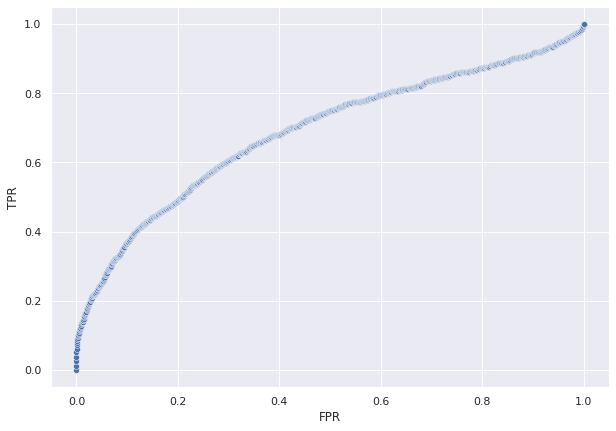

time: 5.36 s (started: 2022-07-22 10:33:28 +00:00)


In [104]:
sns.scatterplot(data=lr_model.summary.roc.toPandas(), x="FPR", y="TPR")
plt.show()

In [105]:
print(f"Area under ROC: {lr_model.summary.areaUnderROC}")

Area under ROC: 0.6884198236195141
time: 53.3 ms (started: 2022-07-22 10:33:33 +00:00)


### Model Evaluation

In [106]:
result_test = lr_model.evaluate(df_test)

time: 1min 41s (started: 2022-07-22 10:33:33 +00:00)


#### recallByLabel

In [107]:
result_test.recallByLabel

[1.0, 0.0]

time: 2.83 s (started: 2022-07-22 10:35:15 +00:00)


In [108]:
results_df = result_test.predictions.coalesce(1)

time: 62.8 ms (started: 2022-07-22 10:35:17 +00:00)


#### Converting Vector datatype to ArrayType

Converting probability column vector to ArrayType and then creating new columns for each TARGET class probability.

In [109]:
def vector_to_array(col):
    def vector_to_array_(v):
        return v.toArray().tolist()
    return F.udf(vector_to_array_, T.ArrayType(T.DoubleType())).asNondeterministic()(col)

time: 2.74 ms (started: 2022-07-22 10:35:17 +00:00)


In [110]:
results_df = results_df.withColumn("probability", vector_to_array("probability")) \
                        .select(results_df.columns + [F.col("probability")[i] for i in range(2)])


time: 160 ms (started: 2022-07-22 10:35:17 +00:00)


In [111]:
results_df = results_df.withColumn("prediction", F.col("prediction").cast(T.IntegerType()))

time: 60.1 ms (started: 2022-07-22 10:35:18 +00:00)


In [112]:
results_summary_df = results_df.select([label_column, "probability", "prediction"] + [F.col("probability")[i] for i in range(2)])

time: 59.1 ms (started: 2022-07-22 10:35:18 +00:00)


### Evaluating Metrics

In [113]:
results_summary_df.groupBy(label_column, "prediction").count().show()
results_pd = results_summary_df.toPandas()

+-----------------+----------+-----+
|DELINQUENT_smoted|prediction|count|
+-----------------+----------+-----+
|                1|         0|   46|
|                0|         0|10733|
+-----------------+----------+-----+

time: 1min 49s (started: 2022-07-22 10:35:18 +00:00)


In [116]:
confusion_matrix_pd = results_pd.groupby([label_column, "prediction"]).size().reset_index(name="count")
confusion_matrix_pd.head()

,DELINQUENT_smoted,prediction,count
0,0,0,10733
1,1,0,46


time: 19.5 ms (started: 2022-07-22 10:39:12 +00:00)


In [117]:
TP = confusion_matrix_pd[(confusion_matrix_pd[label_column]==1) & (confusion_matrix_pd.prediction==1)]["count"].values
FP = confusion_matrix_pd[(confusion_matrix_pd[label_column]==0) & (confusion_matrix_pd.prediction==1)]["count"].values
FN = confusion_matrix_pd[(confusion_matrix_pd[label_column]==1) & (confusion_matrix_pd.prediction==0)]["count"].values
TN = confusion_matrix_pd[(confusion_matrix_pd[label_column]==0) & (confusion_matrix_pd.prediction==0)]["count"].values

time: 8.28 ms (started: 2022-07-22 10:39:16 +00:00)


In [118]:
TP = TP[0] if bool(TP) else 0
FP = FP[0] if bool(FP) else 0
TN = TN[0] if bool(TN) else 0
FN = FN[0] if bool(FN) else 0

print(f"TP : {TP}")
print(f"FP : {FP}")
print(f"TN : {TN}")
print(f"FN : {FN}")

TP : 0
FP : 0
TN : 10733
FN : 46
time: 5.76 ms (started: 2022-07-22 10:39:33 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



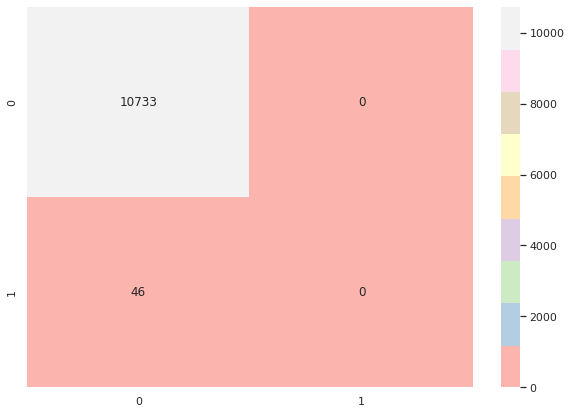

time: 239 ms (started: 2022-07-22 10:39:40 +00:00)


In [119]:
confussion_matrix = np.array([[TN, FP],
                              [FN, TP]])

sns.set(rc={'figure.figsize': (10, 7)})
sns.heatmap(confussion_matrix, annot=True, cmap="Pastel1", fmt="g")
plt.show()

In [ ]:
recall = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)
negative_predictive_value = TN / (TN + FN)

f1_score = 2 * (recall * precision) / (recall + precision)
negative_f1_score = 2 * (specificity * negative_predictive_value) / \
                        (specificity + negative_predictive_value)

print(f"{'Recall/Sensitivity': <25}: {recall}")
print(f"{'Precision': <25}: {precision}")
print(f"{'Specificity': <25}: {specificity}")
print(f"{'Negative Predictive Value': <25}: {negative_predictive_value}")
print(f"{'F1 Score': <25}: {f1_score}")
print(f"{'Negative F1 Score': <25}: {negative_f1_score}")

Precision = 1 means that our Positive Predictive Value is really high but when compared with Recall (0.22), the probability of delinquent detection is really low.

#### Kolmogorov-Smirnov (KS) Statistics

In [120]:
ks_statistic = ks_2samp(results_pd.loc[results_pd[label_column] == 0, "probability[0]"], 
                        results_pd.loc[results_pd[label_column] == 1, "probability[1]"])

ks_statistic

KstestResult(statistic=1.0, pvalue=0.0)

time: 9.67 ms (started: 2022-07-22 10:39:48 +00:00)


## Hyperparameter Optimization

In [118]:
# Garbage Collections
print(f"Garbage Collector collected {gc.collect()} objects.")

Garbage Collector collected 6633 objects.
time: 118 ms (started: 2022-07-22 08:44:11 +00:00)


### CrossValidator

In [ ]:
# Initialising LogisticRegression
log_reg = LogisticRegression(featuresCol="features", 
                             labelCol=label_column, 
                             family="auto")

# Creating Parameter Grid search on LR model
regularization_params = [0.0001, 0.001, 0.01]
num_iteration_params = [5, 10, 20]
probability_threshold = [0.25, 0.3, 0.35, 0.4, 0.5, 0.6]

param_grid = ParamGridBuilder().addGrid(log_reg.regParam, regularization_params) \
                              .addGrid(log_reg.maxIter, num_iteration_params) \
                              .addGrid(log_reg.threshold, probability_threshold) \
                              .build()

class_evaluator = BinaryClassificationEvaluator(labelCol=label_column, 
                                                         metricName="areaUnderPR")

cross_validator = CrossValidator(estimator=log_reg,
                          estimatorParamMaps=param_grid,
                          evaluator=class_evaluator,
                          numFolds=10,
                          parallelism=4)

# Run cross-validation, and choose the best set of parameters.
cross_validator_model = cross_validator.fit(df_train)

# Make predictions on testing data and calculating ROC metrics and model accuracy. 
prediction = cross_validator_model.transform(df_test)

#### Best Model

In [ ]:
best_model_params = cross_validator_model.getEstimatorParamMaps()[np.argmax(cross_validator_model.avgMetrics)]

time: 1.23 ms (started: 2022-07-20 16:52:21 +00:00)


In [ ]:
param_keys = list(best_model_params.keys())
for param in param_keys:
    print(f"{param.name} = {best_model_params[param]}")


regParam = 0.0001
maxIter = 20
threshold = 0.25
time: 1.14 ms (started: 2022-07-20 16:57:07 +00:00)


## Final Model

In [122]:
final_lr = LogisticRegression(featuresCol="features", 
                              labelCol=label_column,
                              regParam=0.0001, 
                              maxIter=20, 
                              threshold=0.25)

final_lr_model = final_lr.fit(df_train)

time: 1min 26s (started: 2022-07-22 10:40:11 +00:00)


In [123]:
final_result_test = final_lr_model.evaluate(df_test)

time: 1min 38s (started: 2022-07-22 10:41:38 +00:00)


In [124]:
final_result_test.recallByLabel

[0.9974843939252772, 0.06521739130434782]

time: 2.73 s (started: 2022-07-22 10:43:16 +00:00)


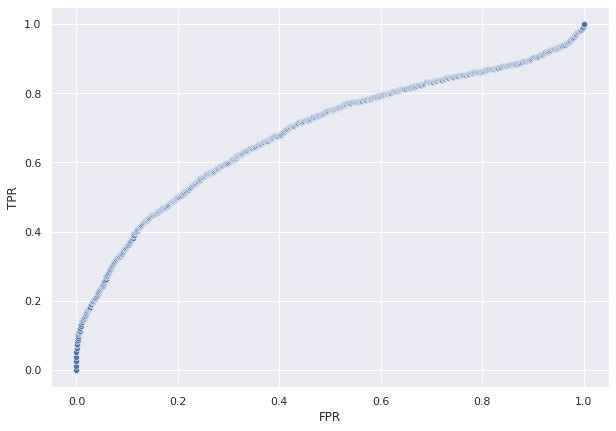

time: 4.45 s (started: 2022-07-22 10:43:19 +00:00)


In [125]:
sns.scatterplot(data=final_lr_model.summary.roc.toPandas(), x="FPR", y="TPR")
plt.show()

In [126]:
print(f"Area under ROC: {lr_model.summary.areaUnderROC}")

Area under ROC: 0.6884198236195141
time: 4.17 ms (started: 2022-07-22 10:43:24 +00:00)


In [127]:
final_results_df = final_result_test.predictions.coalesce(1)
final_results_df = final_results_df.withColumn("probability", vector_to_array("probability")) \
                        .select(final_results_df.columns + [F.col("probability")[i] for i in range(2)])
final_results_df = final_results_df.withColumn("prediction", F.col("prediction").cast(T.IntegerType()))

time: 230 ms (started: 2022-07-22 10:48:02 +00:00)


In [128]:
final_results_summary_df = final_results_df.select([label_column, "probability", "prediction"] + [F.col("probability")[i] for i in range(2)])
final_results_summary_df.groupBy(label_column, "prediction").count().show()
final_results_pd = final_results_summary_df.toPandas()

+-----------------+----------+-----+
|DELINQUENT_smoted|prediction|count|
+-----------------+----------+-----+
|                1|         0|   43|
|                1|         1|    3|
|                0|         0|10706|
|                0|         1|   27|
+-----------------+----------+-----+

time: 2min 9s (started: 2022-07-22 10:48:03 +00:00)


In [129]:
final_confusion_matrix_pd = final_results_pd.groupby([label_column, "prediction"]).size().reset_index(name="count")

TP = final_confusion_matrix_pd[(final_confusion_matrix_pd[label_column]==1) & (final_confusion_matrix_pd.prediction==1)]["count"].values
FP = final_confusion_matrix_pd[(final_confusion_matrix_pd[label_column]==0) & (final_confusion_matrix_pd.prediction==1)]["count"].values
FN = final_confusion_matrix_pd[(final_confusion_matrix_pd[label_column]==1) & (final_confusion_matrix_pd.prediction==0)]["count"].values
TN = final_confusion_matrix_pd[(final_confusion_matrix_pd[label_column]==0) & (final_confusion_matrix_pd.prediction==0)]["count"].values

TP = TP[0] if bool(TP) else 0
FP = FP[0] if bool(FP) else 0
TN = TN[0] if bool(TN) else 0
FN = FN[0] if bool(FN) else 0

print(f"TP : {TP}")
print(f"FP : {FP}")
print(f"TN : {TN}")
print(f"FN : {FN}")

TP : 2
FP : 27
TN : 10706
FN : 44
time: 29.3 ms (started: 2022-07-22 10:51:05 +00:00)


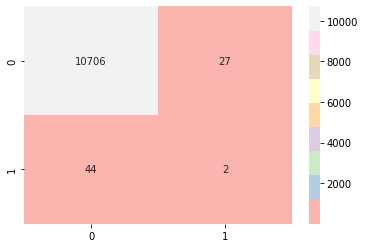

Recall/Sensitivity       : 0.043478260869565216
Precision                : 0.06896551724137931
Specificity              : 0.9974843939252772
Negative Predictive Value: 0.995906976744186
F1 Score                 : 0.05333333333333333
Negative F1 Score        : 0.9966950612111902


In [9]:
final_confussion_matrix = np.array([[TN, FP],
                              [FN, TP]])
sns.heatmap(final_confussion_matrix, annot=True, cmap="Pastel1", fmt="g")
plt.show()
recall = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)
negative_predictive_value = TN / (TN + FN)

f1_score = 2 * (recall * precision) / (recall + precision)
negative_f1_score = 2 * (specificity * negative_predictive_value) / \
                        (specificity + negative_predictive_value)

print(f"{'Recall/Sensitivity': <25}: {recall}")
print(f"{'Precision': <25}: {precision}")
print(f"{'Specificity': <25}: {specificity}")
print(f"{'Negative Predictive Value': <25}: {negative_predictive_value}")
print(f"{'F1 Score': <25}: {f1_score}")
print(f"{'Negative F1 Score': <25}: {negative_f1_score}")

In [131]:
ks_statistic = ks_2samp(final_results_pd.loc[final_results_pd[label_column] == 0, "probability[0]"], 
                        final_results_pd.loc[final_results_pd[label_column] == 1, "probability[1]"])

ks_statistic

KstestResult(statistic=1.0, pvalue=0.0)

time: 8.76 ms (started: 2022-07-22 10:51:17 +00:00)
